In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_error(sorted_data, x, p, is_int=False):
    if is_int:
        x = np.round(x)
    n = len(sorted_data)
    li = np.searchsorted(sorted_data, x, side="left")
    ri = np.searchsorted(sorted_data, x, side="right")
    qi = int(p * n)
    if ri < qi:
        return (qi-ri)*1.0/n
    elif li > qi:
        return (li-qi)*1.0/n
    else:
        return 0.0

In [66]:
colormap = {
    "cmoments": "C0",
    "tdigest": "C1",
    "yahoo": "C2",
    "spark_gk": "C3",
    "histogram": "C4",
    "sampling": "C5",
}
markers = {
    "cmoments": "x",
    "tdigest": "^",
    "yahoo": "s",
    "spark_gk": "+",
    "histogram": "D",
    "sampling": "o",
}
alg_display_name = {
    "cmoments": "M-Sketch",
    "tdigest": "T-Digest",
    "yahoo": "Merge12",
    "spark_gk": "GK",
    "histogram": "EW-Histogram",
    "sampling": "Sampling",
}

In [131]:
datasets = ["milan", "exponential"]
dataset_paths = {
    "milan": ("../../datasets/internet-mi-2013-11-01_09.csv","internet"),
    "exponential": ("../../datasets/exponential_10M.csv","x")
}
sorted_vals = {}
for d in datasets:
    print(d)
    dpath, dcol = dataset_paths[d]
    df = pd.read_csv(dpath)
    sorted_vals[d] = np.sort(df[dcol])

milan
exponential


In [156]:
result_path = "../finalresults/"
point_paths = {
    "milan": ["point_milan_m.csv", "point_milan.csv"],
    "exponential": ["point_exp_m.csv", "point_exp.csv"]
}
merge_paths = {
    "milan": ["merge_milan_m.csv", "merge_milan.csv"],
    "exponential": ["merge_exp_m.csv", "merge_exp.csv"]
}
p_datasets = ["milan", "exponential"]
m_datasets = ["milan", "exponential"]

point_dfs = {}
for dname in p_datasets:
    point_dfs[dname] = pd.concat([pd.read_csv(result_path+ppath) for ppath in point_paths[dname]])

merge_dfs = {}
for dname in m_datasets:
    merge_dfs[dname] = pd.concat([pd.read_csv(result_path+ppath) for ppath in merge_paths[dname]])

In [152]:
def process(df, svals):
    dft = df[
        (df["trial"] > 0)
    ].groupby(
        ["sketch", "size_param", "q"]
    ).mean()
    dft = dft.reset_index()
    dft["error"] = dft.apply(
        lambda r: get_error(
            svals, r["quantile_estimate"], r["q"],
        ),
        axis=1
    )
    dft["rerror"] = dft["error"] / np.minimum(dft["q"],(1-dft["q"]))
    dfg = dft.groupby([
        "sketch", "size_param"
    ]).mean()
    dfs = dfg.reset_index().sort_values(["size_param"])
    return dfs

In [157]:
point_results_processed = {}
for dname in p_datasets:
    svals = sorted_vals[dname]
    df = point_dfs[dname]
    dfs = process(df, svals)
    point_results_processed[dname] = dfs

In [158]:
merge_results_processed = {}
for dname in m_datasets:
    svals = sorted_vals[dname]
    df = merge_dfs[dname]
    dfs = process(df, svals)
    merge_results_processed[dname] = dfs

In [137]:
point_results_processed["milan"].columns

Index(['sketch', 'size_param', 'q', 'quantile_estimate', 'train_time',
       'bound_size', 'trial', 'space', 'query_time', 'n', 'error', 'rerror'],
      dtype='object')

# Point Accuracy

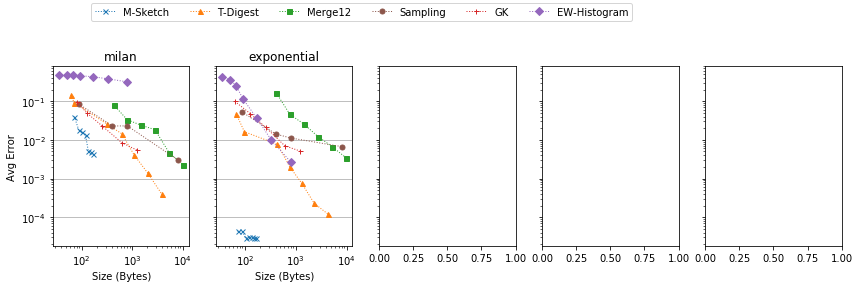

In [188]:
sketches = ["cmoments", "tdigest", "yahoo", "sampling", "spark_gk", "histogram"]
f, axs = plt.subplots(1,5, figsize=(12,3.5), sharey=True)
for di in range(len(datasets)):
    dname = datasets[di]
    ax = axs[di]
    df = point_results_processed[dname]
    lines = []
    labels = []
    for alg in sketches:
        c_df = df[df["sketch"] == alg]
        l, = ax.loglog(
            c_df["space"],
            c_df["error"], 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1
        )
        lines.append(l)
        labels.append(alg_display_name[alg])

    ax.set_title(dname)
    ax.set_xlabel("Size (Bytes)")
    ax.yaxis.grid(True)
    if di == 0:
        ax.set_ylabel("Avg Error")

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.10, 1.05, 1., .102), ncol=6, loc=2
)
f.tight_layout()
f.savefig("point_accuracy.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Point Update

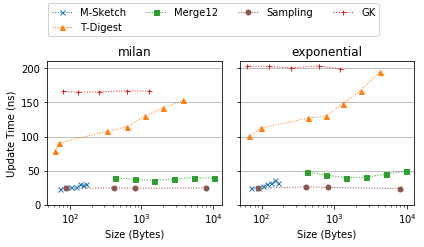

In [195]:
sketches = ["cmoments", "tdigest", "yahoo", "sampling", "spark_gk"]
f, axs = plt.subplots(1,2, figsize=(6,3), sharey=True)
for di in range(len(datasets)):
    dname = datasets[di]
    ax = axs[di]
    df = point_results_processed[dname]
    lines = []
    labels = []
    for alg in sketches:
        c_df = df[df["sketch"] == alg]
        l, = ax.semilogx(
            c_df["space"],
            c_df["train_time"] / c_df["n"], 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1
        )
        lines.append(l)
        labels.append(alg_display_name[alg])

    ax.set_title(dname)
    ax.set_ylim(0, 210)
    ax.set_xlabel("Size (Bytes)")
    ax.yaxis.grid(True)
    if di == 0:
        ax.set_ylabel("Update Time (ns)")

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.10, 1.05, 1., .102), ncol=4, loc=2
)
f.tight_layout()
f.savefig("point_update.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Point Solve Time

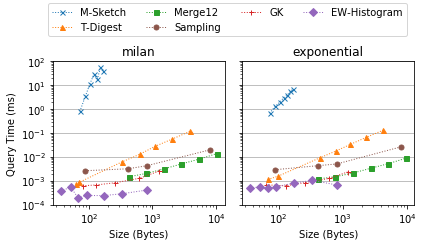

In [194]:
sketches = ["cmoments", "tdigest", "yahoo", "sampling", "spark_gk", "histogram"]
f, axs = plt.subplots(1,2, figsize=(6,3), sharey=True)
for di in range(len(datasets)):
    dname = datasets[di]
    ax = axs[di]
    df = point_results_processed[dname]
    lines = []
    labels = []
    for alg in sketches:
        c_df = df[df["sketch"] == alg]
        l, = ax.loglog(
            c_df["space"],
            c_df["query_time"] * 1e-6, 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1
        )
        lines.append(l)
        labels.append(alg_display_name[alg])

    ax.set_title(dname)
    ax.set_ylim(1e-4, 100)
    ax.set_xlabel("Size (Bytes)")
    ax.yaxis.grid(True)
    if di == 0:
        ax.set_ylabel("Query Time (ms)")

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.10, 1.05, 1., .102), ncol=4, loc=2
)
f.tight_layout()
f.savefig("point_solve.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Point Bound Size

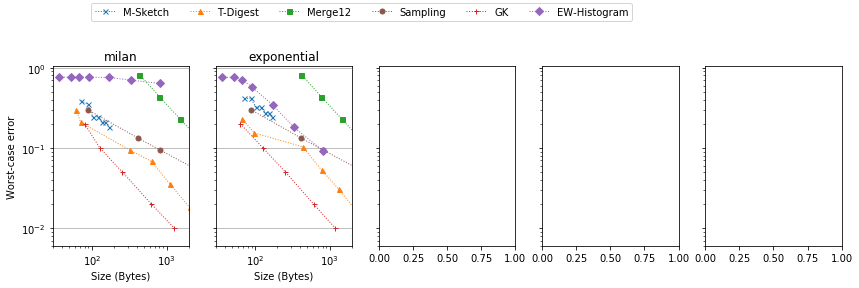

In [197]:
sketches = ["cmoments", "tdigest", "yahoo", "sampling", "spark_gk", "histogram"]
f, axs = plt.subplots(1,5, figsize=(12,3.5), sharey=True)
for di in range(len(datasets)):
    dname = datasets[di]
    ax = axs[di]
    df = point_results_processed[dname]
    lines = []
    labels = []
    for alg in sketches:
        c_df = df[df["sketch"] == alg]
        l, = ax.loglog(
            c_df["space"],
            c_df["bound_size"], 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1
        )
        lines.append(l)
        labels.append(alg_display_name[alg])

    ax.set_title(dname)
    ax.set_xlim(30, 2000)
    ax.set_xlabel("Size (Bytes)")
    ax.yaxis.grid(True)
    if di == 0:
        ax.set_ylabel("Worst-case error")

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.10, 1.05, 1., .102), ncol=6, loc=2
)
f.tight_layout()
f.savefig("point_bound.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Merge Time

In [192]:
merge_results_processed["milan"].columns

Index(['sketch', 'size_param', 'q', 'quantile_estimate', 'train_time',
       'merge_time', 'bound_size', 'trial', 'space', 'query_time', 'n',
       'error', 'rerror'],
      dtype='object')

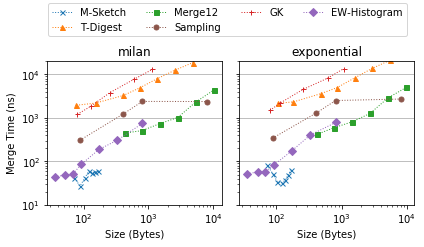

In [193]:
sketches = ["cmoments", "tdigest", "yahoo", "sampling", "spark_gk", "histogram"]
f, axs = plt.subplots(1,2, figsize=(6,3), sharey=True)
for di in range(len(m_datasets)):
    dname = m_datasets[di]
    ax = axs[di]
    df = merge_results_processed[dname]
    lines = []
    labels = []
    for alg in sketches:
        c_df = df[df["sketch"] == alg]
        l, = ax.loglog(
            c_df["space"],
            c_df["merge_time"] / c_df["n"], 
            label=alg_display_name[alg],
            marker=markers[alg],
            color=colormap[alg],
            markersize=5,
            ls="dotted",
            lw=1
        )
        lines.append(l)
        labels.append(alg_display_name[alg])

    ax.set_title(dname)
    ax.set_ylim(10, 2e4)
    ax.set_xlabel("Size (Bytes)")
    ax.yaxis.grid(True)
    if di == 0:
        ax.set_ylabel("Merge Time (ns)")

lgd = f.legend(
    lines, labels,
    bbox_to_anchor=(0.10, 1.05, 1., .102), ncol=4, loc=2
)
f.tight_layout()
f.savefig("merge_time.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')